In [2]:
from IPython.display import Audio, display
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from transformers import Wav2Vec2FeatureExtractor, Data2VecAudioForXVector,Wav2Vec2Processor, Data2VecAudioModel, Data2VecAudioForAudioFrameClassification
from datasets import load_dataset
import os
import math
import scipy
import librosa
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time


# ---------------------------- Preprocessing Audio File Functions -----------------------

In [3]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

# Load Dataset Example Audio Files

Reusing dataset librispeech_asr_demo (/home/valeriopuglisi/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_demo/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


audios.shape:93680
torch.Size([1, 93680])
Sample Rate: 16000
Shape: (1, 93680)
Dtype: torch.float32
 - Max:      0.388
 - Min:     -0.339
 - Mean:    -0.000
 - Std Dev:  0.062

tensor([[0.0024, 0.0021, 0.0020,  ..., 0.0004, 0.0006, 0.0010]])



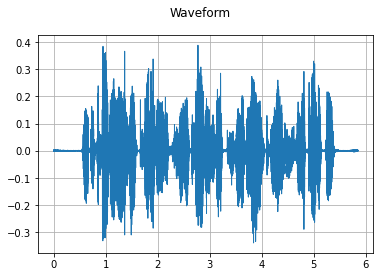

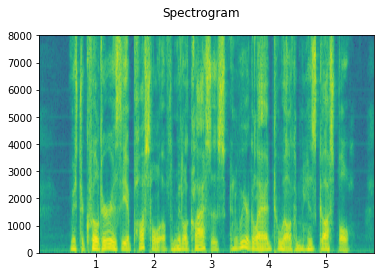

In [4]:

dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

audios = dataset[0]["audio"]["array"]
print("audios.shape:{}".format(len(audios)))

audios_torch  = torch.from_numpy(audios).reshape([1, len(audios)])
print(audios_torch.shape)
print_stats(audios_torch, sample_rate=sampling_rate)
plot_waveform(audios_torch, sampling_rate)
plot_specgram(audios_torch, sampling_rate)
play_audio(audios_torch, sampling_rate)

# Experiment 1 : Data2VecAudioModel with 1 audio file as input

Some weights of the model checkpoint at facebook/data2vec-audio-base-960h were not used when initializing Data2VecAudioModel: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Data2VecAudioModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Data2VecAudioModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


inputs:{'input_values': tensor([[0.0386, 0.0337, 0.0322,  ..., 0.0070, 0.0095, 0.0169]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}
inputs[input_values].shape:torch.Size([1, 93680])
Sample Rate: 16000
Shape: (1, 93680)
Dtype: torch.float32
 - Max:      6.263
 - Min:     -5.475
 - Mean:    -0.000
 - Std Dev:  1.000

tensor([[0.0386, 0.0337, 0.0322,  ..., 0.0070, 0.0095, 0.0169]])



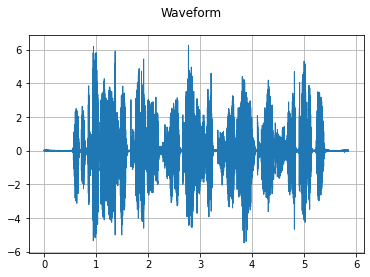

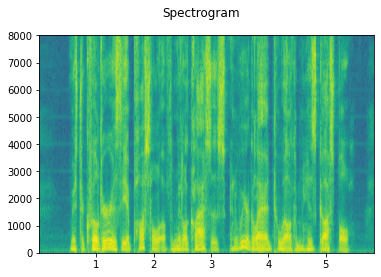

torch.Size([1, 292, 768])
torch.Size([292, 768])


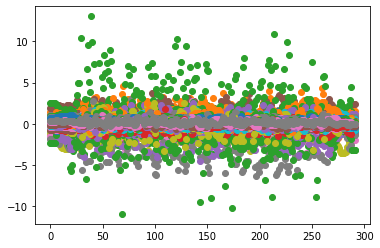

In [5]:


processor = Wav2Vec2Processor.from_pretrained("facebook/data2vec-audio-base-960h")
model = Data2VecAudioModel.from_pretrained("facebook/data2vec-audio-base-960h")

# audio file is decoded on the fly
inputs = processor(audios, sampling_rate=sampling_rate, return_tensors="pt")
print("inputs:{}".format(inputs))
print("inputs[input_values].shape:{}".format(inputs["input_values"].shape))

print_stats(inputs["input_values"], sample_rate=sampling_rate)
plot_waveform(inputs["input_values"], sampling_rate)
plot_specgram(inputs["input_values"], sampling_rate)
play_audio(inputs["input_values"], sampling_rate)

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print(last_hidden_states.shape)
print(last_hidden_states.squeeze(dim=0).shape )
plt.plot(last_hidden_states.squeeze(dim=0),linestyle="",marker="o")
plt.show()

# Experiments 2: Data2VecAudioForAudioFrameClassification

Reusing dataset librispeech_asr_demo (/home/valeriopuglisi/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_demo/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


Sample Rate: 16000
Shape: (1, 93680)
Dtype: torch.float32
 - Max:      6.263
 - Min:     -5.475
 - Mean:    -0.000
 - Std Dev:  1.000

tensor([[0.0386, 0.0337, 0.0322,  ..., 0.0070, 0.0095, 0.0169]])



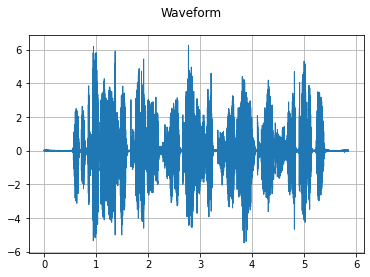

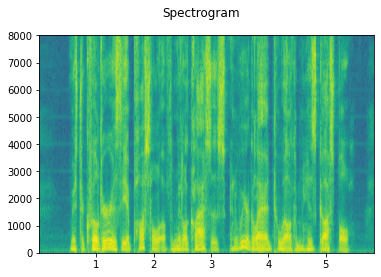

torch.Size([1462, 2])


[1, 1]

In [6]:


dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("hf-internal-testing/tiny-random-data2vec-audio-frame")
model = Data2VecAudioForAudioFrameClassification.from_pretrained("hf-internal-testing/tiny-random-data2vec-audio-frame")

# audio file is decoded on the fly
inputs = feature_extractor(audios, return_tensors="pt", sampling_rate=sampling_rate)

print_stats(inputs["input_values"], sample_rate=sampling_rate)
plot_waveform(inputs["input_values"], sampling_rate)
plot_specgram(inputs["input_values"], sampling_rate)
play_audio(inputs["input_values"], sampling_rate)

with torch.no_grad():
    logits = model(**inputs).logits

probabilities = torch.sigmoid(logits[0])
print(probabilities.shape)
# labels is a one-hot array of shape (num_frames, num_speakers)
labels = (probabilities > 0.5).long()
labels[0].tolist()

# Experiment 3 (Speaker Verification)

## Experiment 3.1:  
### Step 1: Load Dataset Audio Files <br> Step2: Load Data2VecAudioForXVector Model <br> Step3: Evaluate Data2VecAudioForXVector Model

Reusing dataset librispeech_asr_demo (/home/valeriopuglisi/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_demo/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


=========> DATASET AUDIO FILES ====================
----------------------------
(93680,)
<class 'numpy.ndarray'>
torch.Size([1, 93680])
Sample Rate: 16000
Shape: (1, 93680)
Dtype: torch.float32
 - Max:      0.388
 - Min:     -0.339
 - Mean:    -0.000
 - Std Dev:  0.062

tensor([[0.0024, 0.0021, 0.0020,  ..., 0.0004, 0.0006, 0.0010]])



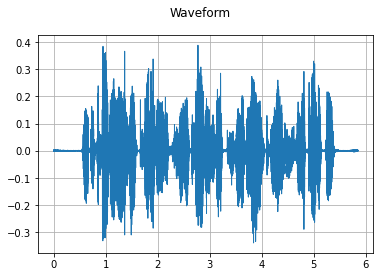

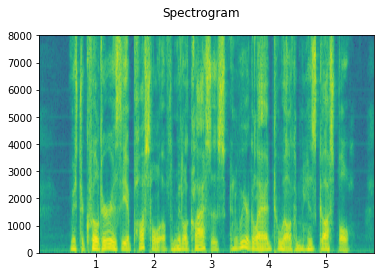

----------------------------
(77040,)
<class 'numpy.ndarray'>
torch.Size([1, 77040])
Sample Rate: 16000
Shape: (1, 77040)
Dtype: torch.float32
 - Max:      0.616
 - Min:     -0.521
 - Mean:    -0.000
 - Std Dev:  0.081

tensor([[-1.5259e-04, -9.1553e-05, -1.8311e-04,  ...,  9.7656e-04,
          9.4604e-04, -4.8828e-04]])



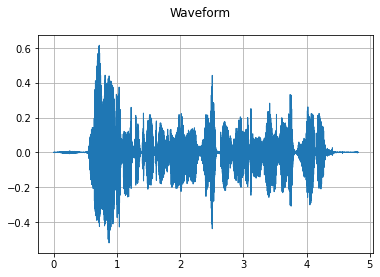

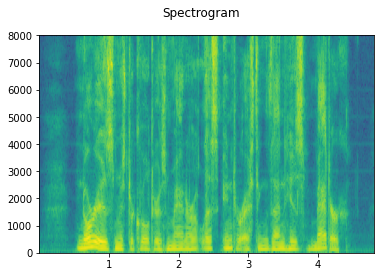

=========> FEATURES EXTRACTED DATASET AUDIO FILES ====================
<class 'torch.Tensor'>
torch.Size([93680])
Sample Rate: 16000
Shape: (1, 93680)
Dtype: torch.float32
 - Max:      6.263
 - Min:     -5.475
 - Mean:    -0.000
 - Std Dev:  1.000

tensor([[0.0386, 0.0337, 0.0322,  ..., 0.0070, 0.0095, 0.0169]])



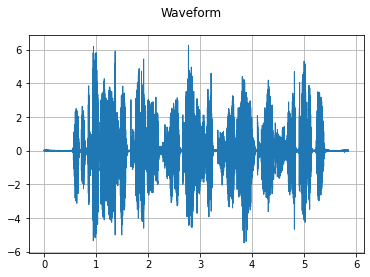

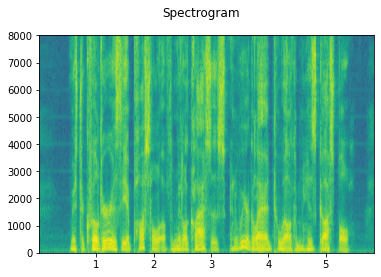

<class 'torch.Tensor'>
torch.Size([93680])
Sample Rate: 16000
Shape: (1, 93680)
Dtype: torch.float32
 - Max:      8.386
 - Min:     -7.086
 - Mean:     0.000
 - Std Dev:  1.000

tensor([[-0.0017, -0.0009, -0.0022,  ...,  0.0003,  0.0003,  0.0003]])



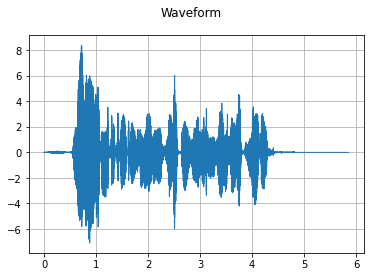

/home/valeriopuglisi/.conda/envs/DLAABE/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


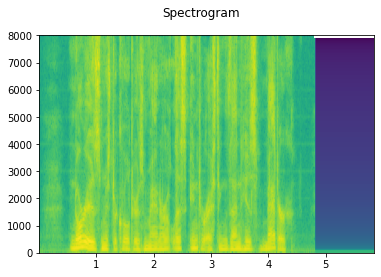

embeddings.shape:torch.Size([2, 512])


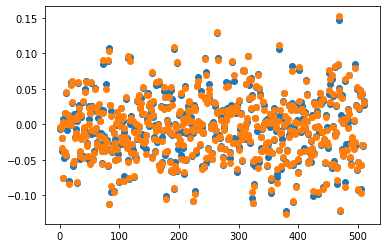

Speakers are the same!


1.0

In [12]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate
audio_files = [d["array"] for d in dataset[:2]["audio"]]

print("=========> DATASET AUDIO FILES ====================")
for audio in audio_files:
    print("----------------------------")
    print(audio.shape)
    print(type(audio))
    audio_torch  = torch.from_numpy(audio).reshape([1, len(audio)])
    print(audio_torch.shape)
    print_stats(audio_torch, sample_rate=sampling_rate)
    plot_waveform(audio_torch, sampling_rate)
    plot_specgram(audio_torch, sampling_rate)
    play_audio(audio_torch, sampling_rate)


# 3.1: Load Data2VecAudioForXVector Model
# audio file is decoded on the fly
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("hf-internal-testing/tiny-random-data2vec-xvector")
inputs = feature_extractor(audio_files, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

print("=========> FEATURES EXTRACTED DATASET AUDIO FILES ====================")
for input in inputs["input_values"]:
    print(type(input))
    print(input.shape)
    input_torch  = input.reshape([1, len(input)])
    print_stats(input_torch, sample_rate=sampling_rate)
    plot_waveform(input_torch, sampling_rate)
    plot_specgram(input_torch, sampling_rate)
    play_audio(input_torch, sampling_rate)

    
model = Data2VecAudioForXVector.from_pretrained("hf-internal-testing/tiny-random-data2vec-xvector")
with torch.no_grad():
    embeddings = model(**inputs).embeddings

embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()
print("embeddings.shape:{}".format(embeddings.shape))
plt.plot(embeddings[0],linestyle="",marker="o")
plt.plot(embeddings[1],linestyle="",marker="o")
plt.show()

## 3.1: Data2VecAudioForXVector apply Matrix Cosine Similarity for embeddings
# the resulting embeddings can be used for cosine similarity-based retrieval
cosine_sim = torch.nn.CosineSimilarity(dim=-1)
similarity = cosine_sim(embeddings[0], embeddings[1])
threshold = 0.99  # the optimal threshold is dataset-dependent
if similarity < threshold:
    print("Speakers are not the same!")
else:
    print("Speakers are the same!")
round(similarity.item(), 2)

#  Loading into the wild audio files for Data2VecAudioForXVector

==> RAW: source_1_waveform_path
Sample Rate: 16000
Shape: (1, 41610)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -1.000
 - Mean:    -0.001
 - Std Dev:  0.235

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0518e-05, 0.0000e+00,
         0.0000e+00]])



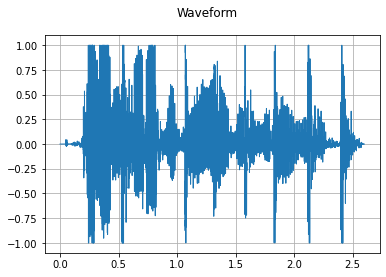

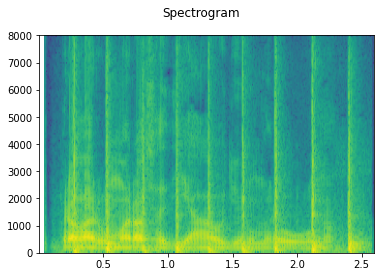

==> RAW: source_2_waveform_path
Sample Rate: 16000
Shape: (1, 51270)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -0.657
 - Mean:    -0.000
 - Std Dev:  0.089

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0008, 0.0009, 0.0009]])



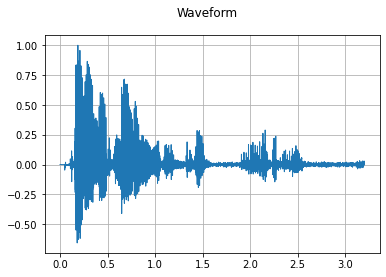

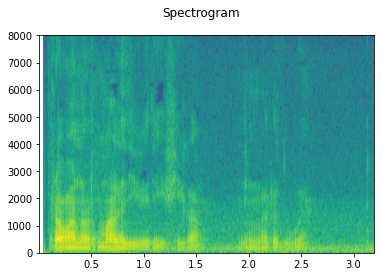

==> RAW: source_3_waveform_path
Sample Rate: 16000
Shape: (1, 59905)
Dtype: torch.float32
 - Max:      0.823
 - Min:     -0.889
 - Mean:    -0.000
 - Std Dev:  0.145

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.0518e-05,
         0.0000e+00]])



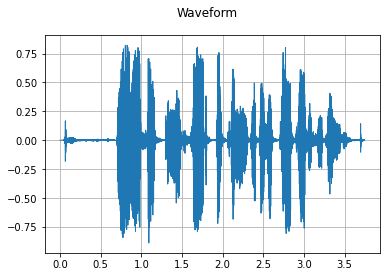

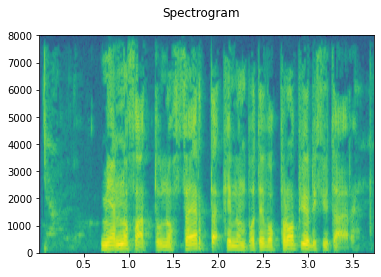

In [26]:
source_1_waveform_path ="/storage/data_itcoin/svoice_space/DeepLearningAudioAnalyzer/audio-be/media/University of Hertfordshire.wav"  
source_2_waveform_path ="/storage/data_itcoin/svoice_space/DeepLearningAudioAnalyzer/audio-be/media/University of Hertfordshire 2.wav"  
source_3_waveform_path ="/storage/data_itcoin/svoice_space/DeepLearningAudioAnalyzer/audio-be/media/University of Hertfordshire 3.wav"  

source_1_waveform, sample_rate_1 = torchaudio.load(source_1_waveform_path)
source_2_waveform, sample_rate_2 = torchaudio.load(source_2_waveform_path)
source_3_waveform, sample_rate_3 = torchaudio.load(source_3_waveform_path)
resample_rate = 16000
if sample_rate_1 != sample_rate_2 and sample_rate_2 != sample_rate_3 and sample_rate_1 != resample_rate:
    source_1_waveform = F.resample(source_1_waveform, sample_rate_1, resample_rate)
    source_2_waveform = F.resample(source_2_waveform, sample_rate_2, resample_rate)
    source_3_waveform = F.resample(source_3_waveform, sample_rate_3, resample_rate)

print("==> RAW: source_1_waveform_path")
print_stats(source_1_waveform, sample_rate=sample_rate_1)
plot_waveform(source_1_waveform, sample_rate_1)
plot_specgram(source_1_waveform, sample_rate_1)
play_audio(source_1_waveform, sample_rate_1)

print("==> RAW: source_2_waveform_path")
print_stats(source_2_waveform, sample_rate=sample_rate_2)
plot_waveform(source_2_waveform, sample_rate_2)
plot_specgram(source_2_waveform, sample_rate_2)
play_audio(source_2_waveform, sample_rate_2)

print("==> RAW: source_3_waveform_path")
print_stats(source_3_waveform, sample_rate=sample_rate_3)
plot_waveform(source_3_waveform, sample_rate_3)
plot_specgram(source_3_waveform, sample_rate_3)
play_audio(source_3_waveform, sample_rate_3)


source_1_waveform = source_1_waveform.squeeze().numpy()
source_2_waveform = source_2_waveform.squeeze().numpy()
source_3_waveform = source_3_waveform.squeeze().numpy()




=========> FEATURES EXTRACTED DATASET AUDIO FILES ====================
<class 'torch.Tensor'>
torch.Size([51270])
Sample Rate: 16000
Shape: (1, 51270)
Dtype: torch.float32
 - Max:      4.724
 - Min:     -4.713
 - Mean:     0.000
 - Std Dev:  1.000

tensor([[0.0053, 0.0053, 0.0053,  ..., 0.0053, 0.0053, 0.0053]])



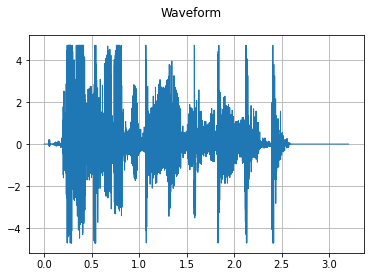

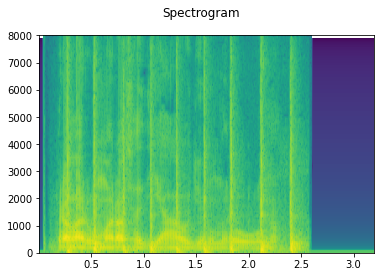

<class 'torch.Tensor'>
torch.Size([51270])
Sample Rate: 16000
Shape: (1, 51270)
Dtype: torch.float32
 - Max:     11.299
 - Min:     -7.419
 - Mean:     0.000
 - Std Dev:  1.000

tensor([[0.0011, 0.0011, 0.0011,  ..., 0.0097, 0.0107, 0.0118]])



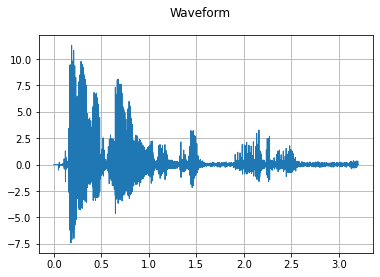

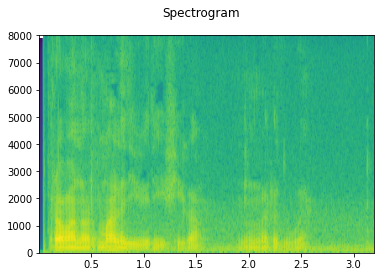

embeddings.shape:torch.Size([2, 512])


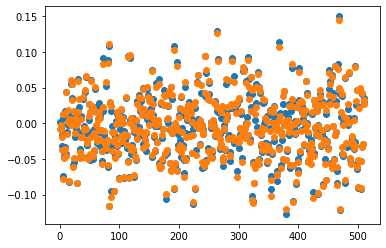

Speakers are the same!


0.99

In [27]:
audio_files = [source_1_waveform, source_2_waveform]
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("hf-internal-testing/tiny-random-data2vec-xvector")
inputs = feature_extractor(audio_files, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
print("=========> FEATURES EXTRACTED DATASET AUDIO FILES ====================")
for input in inputs["input_values"]:
    print(type(input))
    print(input.shape)
    input_torch  = input.reshape([1, len(input)])
    print_stats(input_torch, sample_rate=sampling_rate)
    plot_waveform(input_torch, sampling_rate)
    plot_specgram(input_torch, sampling_rate)
    play_audio(input_torch, sampling_rate)

model = Data2VecAudioForXVector.from_pretrained("hf-internal-testing/tiny-random-data2vec-xvector")
with torch.no_grad():
    embeddings = model(**inputs).embeddings
embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()

print("embeddings.shape:{}".format(embeddings.shape))
plt.plot(embeddings[0], linestyle="", marker="o")
plt.plot(embeddings[1], linestyle="", marker="o")
plt.show()


## 3.1: Data2VecAudioForXVector apply Matrix Cosine Similarity for embeddings
# the resulting embeddings can be used for cosine similarity-based retrieval
cosine_sim = torch.nn.CosineSimilarity(dim=-1)
similarity = cosine_sim(embeddings[0], embeddings[1])
threshold = 0.98 # the optimal threshold is dataset-dependent
if similarity < threshold:
    print("Speakers are not the same!")
else:
    print("Speakers are the same!")
round(similarity.item(), 2)

=========> FEATURES EXTRACTED DATASET AUDIO FILES ====================
<class 'torch.Tensor'>
torch.Size([59905])
Sample Rate: 16000
Shape: (1, 59905)
Dtype: torch.float32
 - Max:     12.213
 - Min:     -8.020
 - Mean:     0.000
 - Std Dev:  1.000

tensor([[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]])



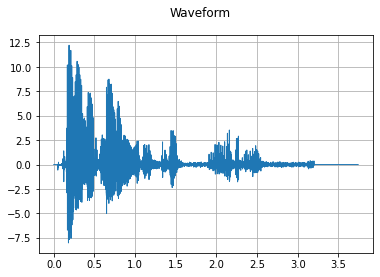

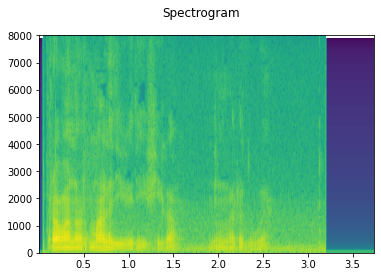

<class 'torch.Tensor'>
torch.Size([59905])
Sample Rate: 16000
Shape: (1, 59905)
Dtype: torch.float32
 - Max:      5.671
 - Min:     -6.130
 - Mean:     0.000
 - Std Dev:  1.000

tensor([[4.2897e-05, 4.2897e-05, 4.2897e-05,  ..., 4.2897e-05, 2.5327e-04,
         4.2897e-05]])



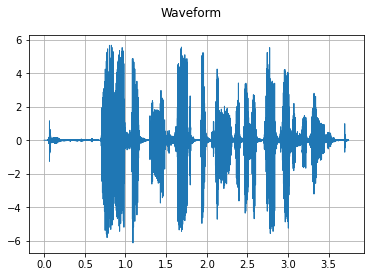

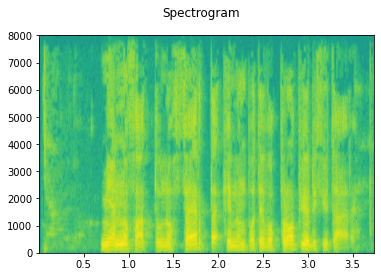

embeddings.shape:torch.Size([2, 512])


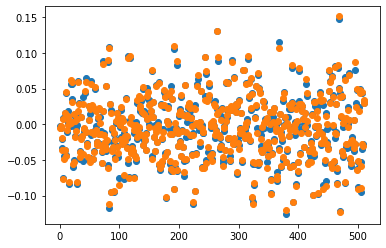

similarity:  0.9967
Speakers are the same!


In [28]:
audio_files = [source_2_waveform, source_3_waveform]
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("hf-internal-testing/tiny-random-data2vec-xvector")
inputs = feature_extractor(audio_files, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
print("=========> FEATURES EXTRACTED DATASET AUDIO FILES ====================")
for input in inputs["input_values"]:
    print(type(input))
    print(input.shape)
    input_torch  = input.reshape([1, len(input)])
    print_stats(input_torch, sample_rate=sampling_rate)
    plot_waveform(input_torch, sampling_rate)
    plot_specgram(input_torch, sampling_rate)
    play_audio(input_torch, sampling_rate)

model = Data2VecAudioForXVector.from_pretrained("hf-internal-testing/tiny-random-data2vec-xvector")
with torch.no_grad():
    embeddings = model(**inputs).embeddings
embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()

print("embeddings.shape:{}".format(embeddings.shape))
plt.plot(embeddings[0], linestyle="", marker="o")
plt.plot(embeddings[1], linestyle="", marker="o")
plt.show()


## 3.1: Data2VecAudioForXVector apply Matrix Cosine Similarity for embeddings
# the resulting embeddings can be used for cosine similarity-based retrieval
cosine_sim = torch.nn.CosineSimilarity(dim=-1)
similarity = cosine_sim(embeddings[0], embeddings[1])
threshold = 0.97 # the optimal threshold is dataset-dependent
print("similarity: ", round(similarity.item(), 4))
if similarity < threshold:
    print("Speakers are not the same!")
else:
    print("Speakers are the same!")